In [2]:
import keras.utils

from Preprocessing.MECO_data_split import concat_MECO_langs, split_into_time_series, lang_list
import numpy as np

In [3]:
data = concat_MECO_langs(lang_list)

In [4]:
X, X_test, y, y_test, demo, demo_test = split_into_time_series(data, length=180)

In [5]:
X = (X - np.mean(X)) / np.std(X)

X_dur = X.T[2].T

X_test_dur = X_test.T[2].T

In [7]:
X

array([[[ 1.63354855e+00, -6.38013212e-01, -6.96010533e-01],
        [ 2.13619201e+00, -6.62178762e-01, -5.38934454e-01],
        [ 2.53734015e+00, -6.76678093e-01, -7.00843644e-01],
        ...,
        [-5.19602013e-01,  8.69533084e-02, -7.56424410e-01],
        [-6.88760868e-01,  1.20785079e-01, -6.74261538e-01],
        [-3.62910001e-02,  9.90360837e-02, -5.89682110e-01]],

       [[-8.21671397e-01, -2.70696842e-01, -5.60683450e-01],
        [-1.30536648e-01, -3.87075551e-02, -5.82432445e-01],
        [-7.95089291e-01, -1.49869088e-01, -4.20523256e-01],
        ...,
        [ 1.66738032e+00, -8.55503168e-01, -8.70386565e-02],
        [ 7.12841071e-01, -6.11431106e-01, -3.64942489e-01],
        [ 1.71571142e+00,  1.11118859e-01, -6.30763547e-01]],

       [[ 1.73504386e+00,  1.86032066e-01, -5.94515221e-01],
        [ 2.04919602e+00, -9.03834269e-01, -1.25703538e-01],
        [-5.32068855e-02, -3.89108040e-01,  2.37388101e-03],
        ...,
        [ 2.11202645e+00,  8.69533084e-02,

In [68]:
X_dur

array([[-0.68157903, -0.71303813, -0.49524439, ..., -0.09111602,
        -0.55332272,  0.09763855],
       [-0.63802029, -0.62834056, -0.51702377, ..., -0.33552899,
        -0.20485275, -0.54122307],
       [-0.70819827, -0.57752203, -0.81709513, ..., -0.58478182,
        -0.53396328, -0.4879846 ],
       ...,
       [-0.75175701, -0.73723743, -0.62834056, ..., -0.46862516,
        -0.53638321, -0.51460384],
       [-0.54848286, -0.39844718,  0.31059242, ..., -0.40086711,
         0.23799451, -0.38150767],
       [-0.85823395, -0.79773569, -0.31858948, ..., -0.26777094,
        -0.73965736, -0.56300244]])

In [43]:
from keras import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Dense, TimeDistributed, Conv1D, MaxPooling1D, Conv1DTranspose

import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU')

In [38]:
class DtwLoss(tf.keras.losses.Loss):
    def __init__(self, batch_size: int = 32):
        super(DtwLoss, self).__init__()
        self.batch_size = batch_size

    def call(self, y_true, y_pred):
        tmp = []
        for item in range(self.batch_size):
            tf.print(f'Working on batch: {item}\n')
            s = y_true[item, :]
            t = y_pred[item, :]
            n, m = len(s), len(t)
            dtw_matrix = []
            for i in range(n + 1):
                line = []
                for j in range(m + 1):
                    if i == 0 and j == 0:
                        line.append(0)
                    else:
                        line.append(np.inf)
                dtw_matrix.append(line)

            for i in range(1, n + 1):
                for j in range(1, m + 1):
                    cost = tf.abs(s[i - 1] - t[j - 1])
                    last_min = tf.reduce_min([dtw_matrix[i - 1][j], dtw_matrix[i][j - 1], dtw_matrix[i - 1][j - 1]])
                    dtw_matrix[i][j] = tf.cast(cost, dtype=tf.float32) + tf.cast(last_min, dtype=tf.float32)

            temp = []
            for i in range(len(dtw_matrix)):
                temp.append(tf.stack(dtw_matrix[i]))

            tmp.append(tf.stack(temp)[n, m])
        return tf.reduce_mean(tmp)

In [46]:
input_img = Input(shape=(180,))
encoder = Dense(128, activation='relu')(input_img)
encoder = Dense(64, activation='relu')(encoder)

encoder = Dense(32, activation='relu')(encoder)

decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
output_img = Dense(180, activation='relu')(decoder)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X_dur, np.float32(X_dur), epochs=10)

Epoch 1/10
72/72 [==============================] - 1s 8ms/step - loss: 0.3517
Epoch 2/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 3/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 4/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 5/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 6/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 7/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 8/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 9/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3509
Epoch 10/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3508


In [47]:
X_pred = autoencoder.predict(X_test_dur)

from sklearn.metrics import r2_score

print(r2_score(X_test_dur, X_pred))

13/13 [==============================] - 0s 4ms/step
-4.594307993125025


In [70]:
X_pred = autoencoder.predict(X_dur)

print(r2_score(X_dur, X_pred))

72/72 [==============================] - 1s 4ms/step
-4.372622433426969


In [48]:
enc_model = Model(input_img, encoder)
X_enc = enc_model.predict(X_dur)
X_test_enc = enc_model.predict(X_test_dur)

13/13 [==============================] - 0s 2ms/step


In [54]:
X1 = np.concatenate([demo, X_enc], axis=1)
X1_test = np.concatenate([demo_test, X_test_enc], axis=1)

In [61]:
from Models.search_methods import search_cv

np.int = int

search, cv = search_cv(X1, np.ravel(y), 'rf', 'Classification', 'Bayes')

KeyboardInterrupt: 

(array([-35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23,
        -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
         -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35]),
 array([0.3799269 , 0.43278193, 0.47796754, 0.53010699, 0.53220449,
        0.47650608, 0.45603932, 0.44695775, 0.4804376 , 0.49352998,
        0.52073718, 0.54739208, 0.51845177, 0.47491309, 0.45689016,
        0.43815276, 0.41382979, 0.39716144, 0.39993888, 0.42827152,
        0.49508318, 0.54096152, 0.5478197 , 0.57579307, 0.53540427,
        0.47748136, 0.43469397, 0.38542225, 0.3735325 , 0.37959845,
        0.39352058, 0.44078268, 0.54393913, 0.65375534, 0.82044066,
        1.        , 0.82044066, 0.65375534, 0.54393913, 0.44078268,
        0.39352058, 0.37959845, 0.3735325 , 0.38542

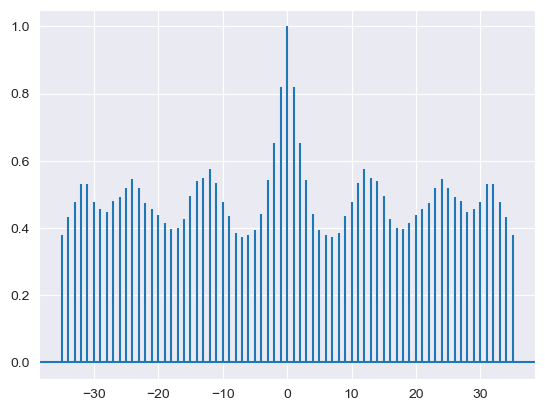

In [6]:
import matplotlib.pyplot as plt

plt.acorr(X.T[0].T[0], maxlags=35)

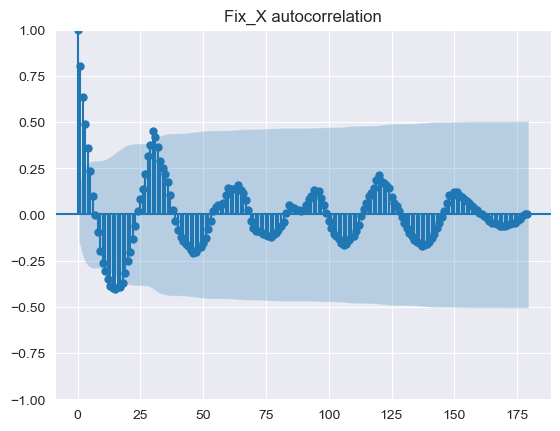

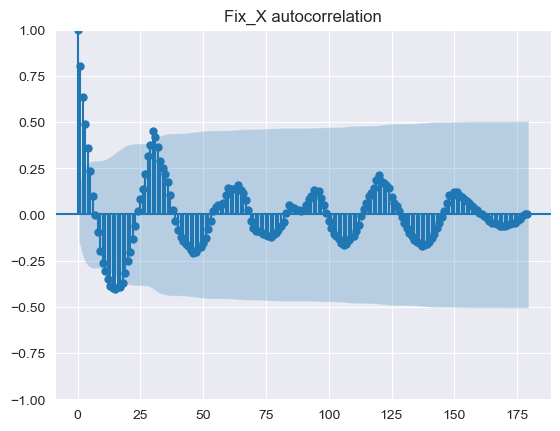

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf

q = plot_acf(X.T[0].T[50], lags=179, alpha=0.05, title='Fix_X autocorrelation')

(array([ 129.,    0.,    0., 1024.,    0.,    0., 1130.,    0.,    0.,
          16.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

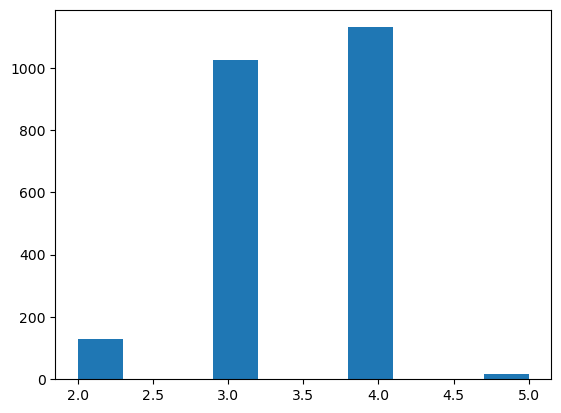

In [100]:
plt.hist(y)

In [ ]:
df = concat_MECO_langs(lang_list)

/var/folders/p0/zb5fdjs17y75059dngt863kw0000gn/T/ipykernel_35410/2821190855.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


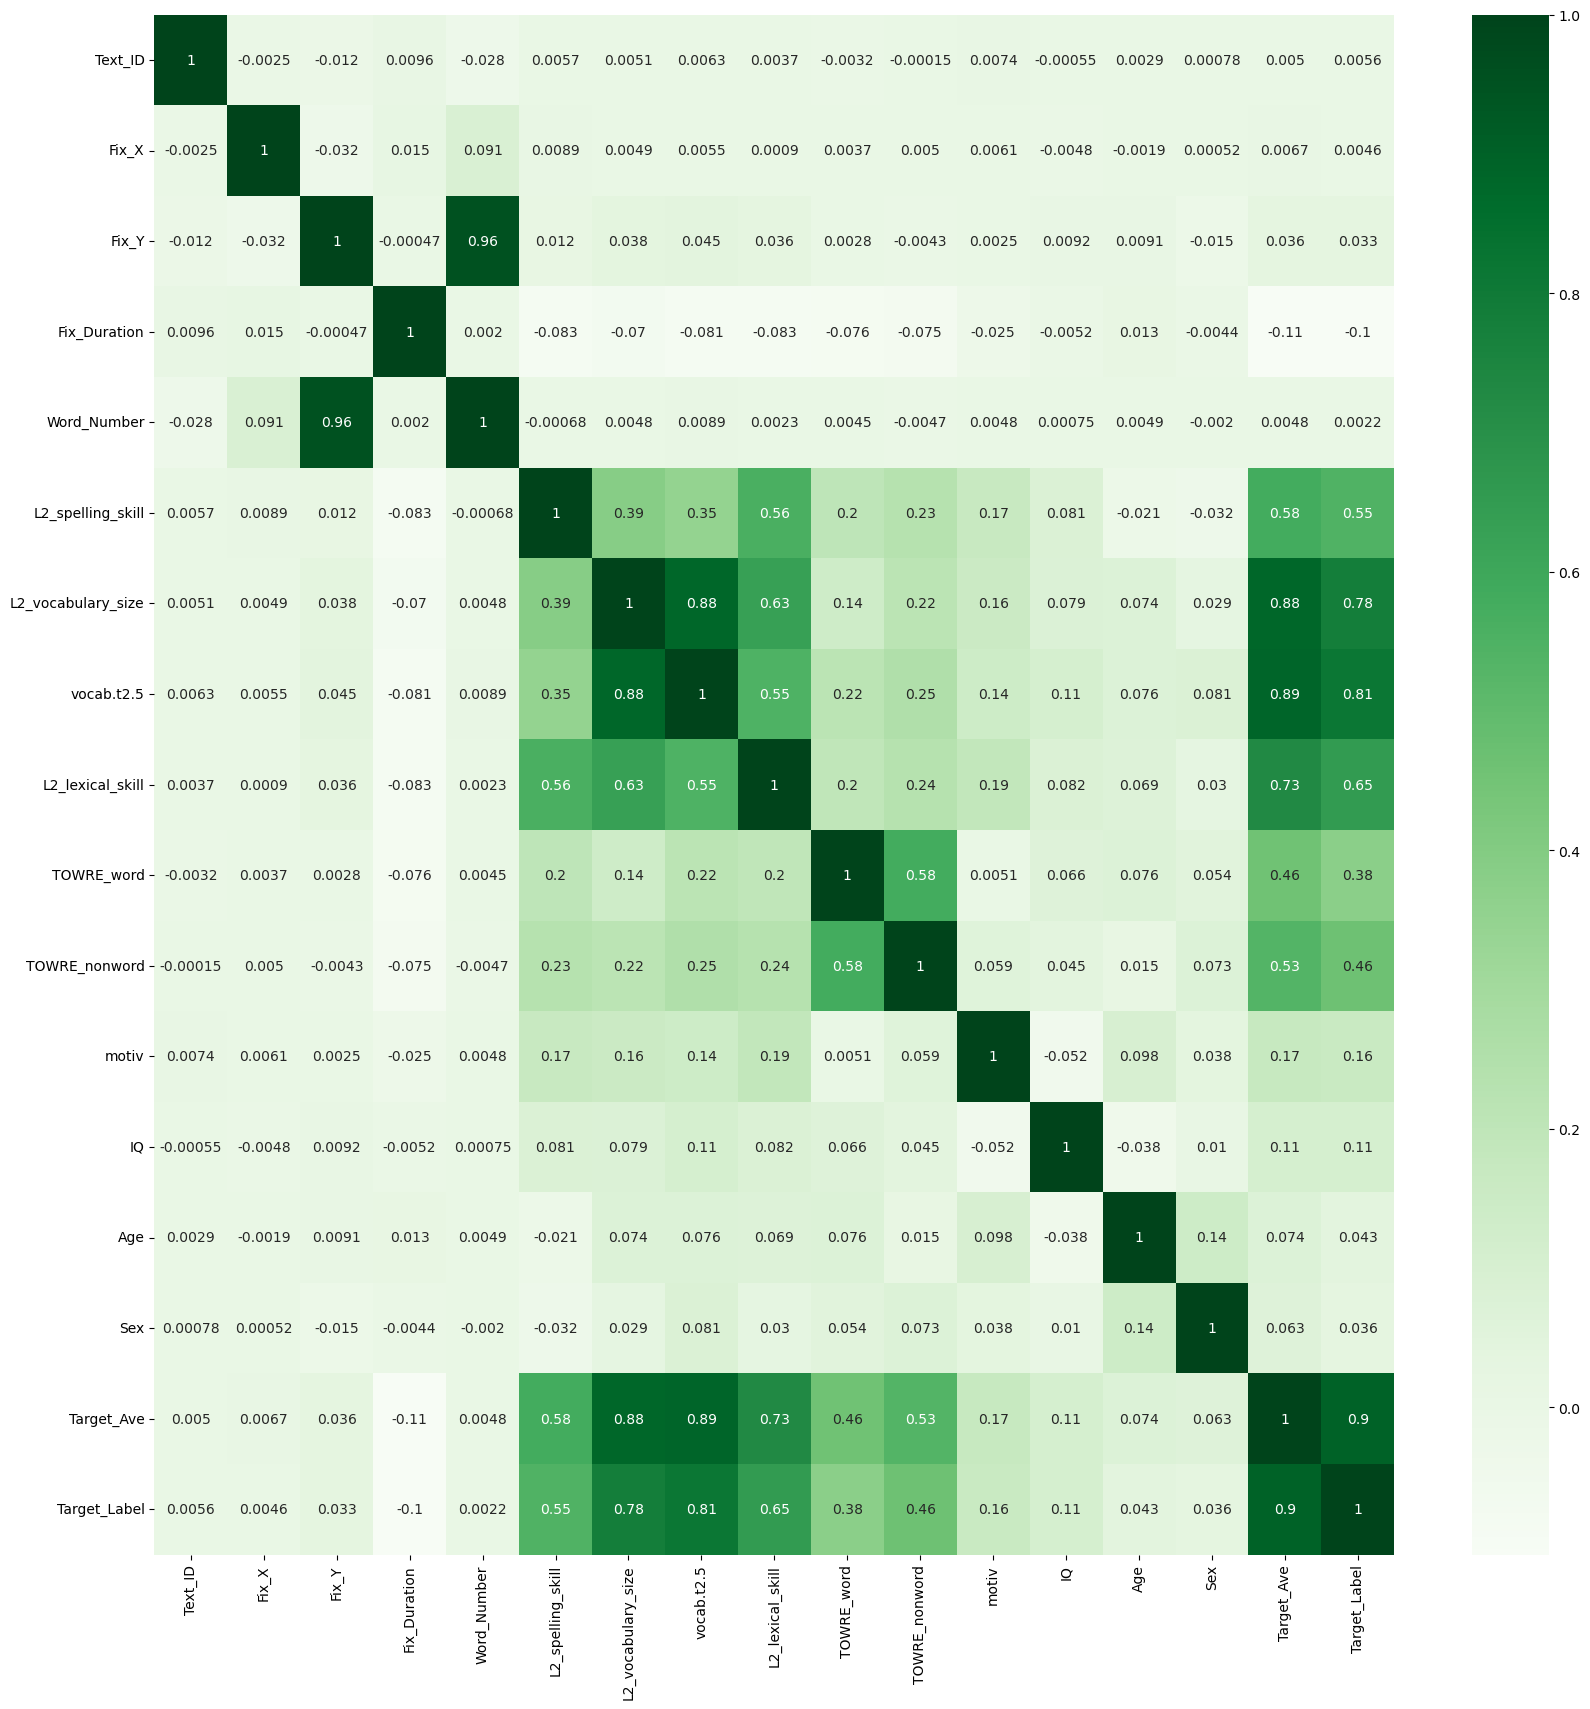

In [106]:
import seaborn as sns

corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

In [111]:
wordn = df[df['SubjectID'] == 'du_4']
wordn = wordn[wordn['Text_ID'] == 1]
print(wordn['Word_Number'])

0        1
1        3
2        2
3        1
4        2
      ... 
148    159
149    160
150    160
151    161
152    161
Name: Word_Number, Length: 153, dtype: int64


Text(0.5, 1.0, 'Sample order of reading')

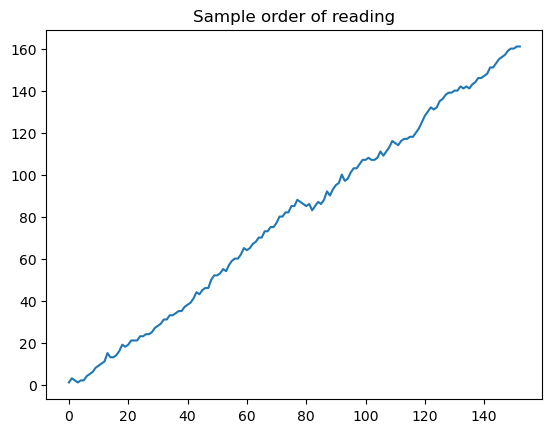

In [116]:
plt.plot(wordn['Word_Number'])
plt.title('Sample order of reading')

In [114]:
wordn.shape

(153, 21)

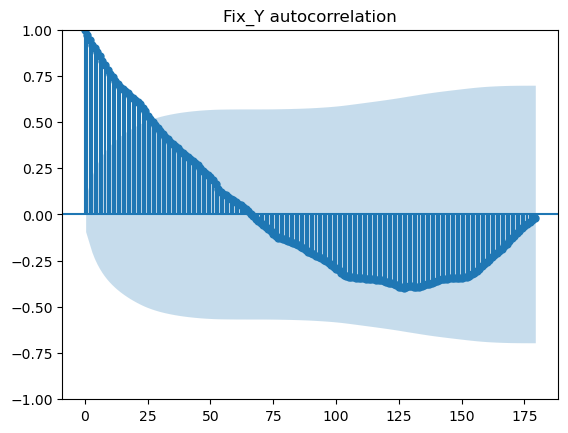

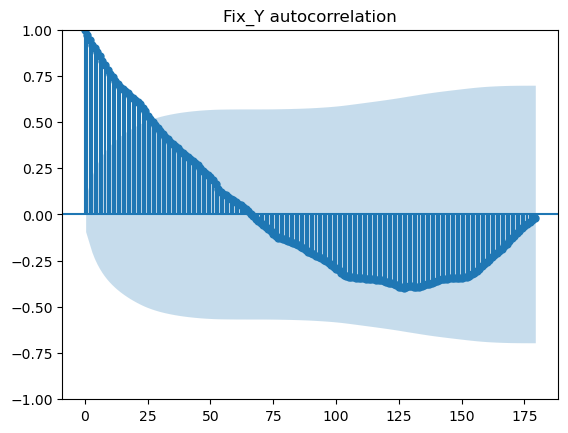

In [117]:
plot_acf(X.T[1].T[10], lags=179, alpha=0.05, title='Fix_Y autocorrelation')

In [3]:
import matplotlib.pyplot as plt

(array([1.143596e+06, 1.069400e+04, 4.140000e+02, 5.800000e+01,
        1.000000e+01, 5.000000e+00, 1.000000e+00, 2.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([2.0000e+00, 5.9570e+02, 1.1894e+03, 1.7831e+03, 2.3768e+03,
        2.9705e+03, 3.5642e+03, 4.1579e+03, 4.7516e+03, 5.3453e+03,
        5.9390e+03]),
 <BarContainer object of 10 artists>)

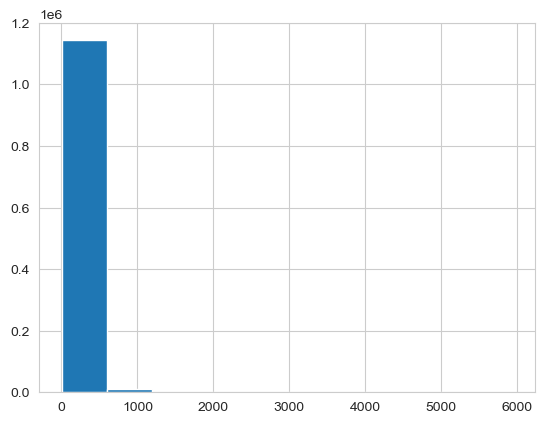

In [4]:
plt.hist(data['Fix_Duration'])